# Sensing Local Field Potentials with a Directional and Scalable Depth Array: the DISC electrode array
## Supplemental Figure 2
- Associated data: Supp fig 2
- Link: (nature excel link)

## Description:
#### This module does the following:
#### Identical to figure 2 code, but only logs the 2mm ring. Is combined with the fig 2 data to create supp. fig 2.
1. Reads .csv data from ANSYS, logging what becomes the peak voltage at each electrode, for each source.
2. Creates sine wave at a specified 16.67 Hz, phase=0 for the source of interest, and a random frequency (40-150 Hz) and phase for all others.
3. Repeat above for all electrodes using the voltage for each.
4. Add (via superposition) the voltage at each timepoint for each electrode.
5. Add gaussian-distributed noise to the electrode at each timepoint.
6. Calculate SNR for each trial
7. Plot resulting SNR for all trials and first trial
- Input: ANSYS .csv output 
- Output: .eps file containing the 2mm ring data for Supp Fig. 2

# Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.projections as proj
import random as rand # Source: https://docs.python.org/3/library/random.html
import numpy as np

# Variables/Data

In [2]:
macro_data_path = '/home/jovyan/ansys_data/supp-fig-1-final.csv'
macro_data_path = '/home/jovyan/ansys_data/8-source-debug/2mm-macro-final.csv'
waveforms_snr_source_index = 0
macro_rms_noise = 2.7 #uV
num_columns = 8
num_rows = 12
num_trials = 50
snr_averages = 5
sample_period = 0.25 #ms
end_time = 60 #ms

# Methods

## Create waveforms
- Function to create waveforms from the amplitude of each signal.
- Returns 'waveforms_trials', which is a 3D array. 
- Axis 0 is a "sheet", for each trial.
- Axis 1 is the waveform for each source.
- Axis 2 is the value at each timepoint.

In [3]:
def create_waveforms(data_arr, rms_noise, signal_index):
    waveforms_trials = []
    waveforms = []
    max_index = np.argmax(data_arr[signal_index])
    
    for _ in range(num_trials):
        waveforms.clear()
        #Always want source we're looking at to be in phase & f=1
        start_phase = rand.randrange(-90, -60, 1) #This way, every waveform is at least f=4f
        stop_phase = rand.randrange(20, 90, 1) #So, from 4f to 9f
        
        for idx, row in enumerate(data_arr): #each row is a source
            new_waveform = []
            if idx == signal_index:
                start_phase, stop_phase = 0, 20
            for phase in np.linspace(start_phase, stop_phase, int(end_time / sample_period)): #loop without pi for easier math. Mult. after. Linspace = (start, stop, #pts)
                #Use max/2 for peak-to-trough voltage
                new_waveform.append((row[max_index])*np.sin((phase*0.1)*np.pi)) #Want to use the same electrode. 
            waveforms.append(new_waveform.copy()) #Add each waveform to the array (trial x)
            #New params for next source
            start_phase = rand.randrange(-90, -60, 1) #This way, every waveform is at least f=4f
            stop_phase = rand.randrange(20, 90, 1) #So, from 4f to 9f
        #Append trial as array, start next trial
        waveforms_trials.append(waveforms.copy()) #Add each trial to the array (all waveforms)
        #add same noise to all sources, at each trial & each time point
    wfms_srcs_trials = np.array(waveforms_trials)
    for trial in wfms_srcs_trials:
        for time in range(int(end_time/sample_period)):
            trial[:, time] = np.add(trial[:,time], rand.gauss(mu=0, sigma=rms_noise))
    
    return wfms_srcs_trials

## Create CAR Waveforms
- now we need a wfm for every electrode for CAR.
- Will create a wfm just for this, and only track the max electrode. Keep frequency same for all
- So, when we pass to SNR calculation function, need to only have that output
- Returns the same output as "create_waveforms" function. We do not need to keep track of all electrodes forever, just for CAR

In [4]:
def create_car_waveforms(data_arr, rms_noise, signal_index, num_electrodes):
    waveforms_trials = [] #contains the CAR'd waveforms per source. NOTE: CAR is computed over ALL sources.
    waveforms = []
    new_waveform = [] #this is actually the resulting wfm of *all* electrodes
    waveform_per_electrode = []
    max_index = np.argmax(data_arr[signal_index])
    
    for _ in range(num_trials):
        waveforms = []
 
        for idx, row in enumerate(data_arr): #each row is a source
            new_waveform = []
            #Always want source we're looking at to be in phase & f=1
            #can't do floats for rand.randrange() routine, so just multiply by 0.1 later
            if idx == signal_index:
                start_phase, stop_phase = 0, 20 #from 0 to 2pi
            else:
                #If not the signal, make random
                start_phase = rand.randrange(-90, -60, 1) #This way, every waveform is at least f=4f
                stop_phase = rand.randrange(20, 90, 1) #So, from 4f to 9f
            for phase in np.linspace(start_phase, stop_phase, int(end_time / sample_period)): #loop without pi for easier math. Mult. after. Linspace = (start, stop, #pts)
                #Use max/2 for peak-to-trough voltage
                waveform_per_electrode = []
                for e_index in range(num_electrodes):
                    elec_val = (row[e_index])*np.sin((phase*0.1)*np.pi) #Want to use the same electrode. 
                    waveform_per_electrode.append(elec_val.copy())
                new_waveform.append(waveform_per_electrode.copy())
            waveforms.append(new_waveform.copy()) #Add each waveform (array, per electrode) to the array (trial x)

        #waveforms is a 3D array (source, time, electrode). 
        waveforms = np.array(waveforms)
        for idx1,row in enumerate(waveforms[0]):
            for idx2,val in enumerate(row):
                waveforms[:,idx1,idx2] += rand.gauss(mu=0, sigma=rms_noise)
        wfms_avg_ref_per_time = np.mean(waveforms, axis=2, keepdims=True) #get 2D array of avg at each source, time (source, time, electrode)
        
        #subtract this avg value from "waveforms"
        waveforms = np.subtract(waveforms, wfms_avg_ref_per_time)
        max_electrode_values = waveforms[signal_index, :, max_index]
        max_electrode_values = np.reshape(max_electrode_values, (1, max_electrode_values.size, 1))
        waveforms = np.add(waveforms, max_electrode_values / num_electrodes)
        
        #Append trial (only max electrode) as array, start next trial
        waveforms_trials.append(waveforms[:, :, max_index]) #Add each trial to the array (all waveforms, only best electrode)

    np_wfms_trials = np.array(waveforms_trials)
    return np_wfms_trials

## Calculate SNR (each trial)
- Function to calculate SNR of the waveforms at each successive averaged trial.
- Takes waveforms_trials and source_index (which row is the source?) as arguments.
- Returns "snr_vec", which is the SNR of each trial. Size [(#trials) x 1].

In [5]:
def calculate_snr_each_trial(waveforms_trials, source_index, rms_noise):
    snr_vec, signal_vec, noise_vec = [], [], []
    
    for trial_stats in range(num_trials):
        wfms = waveforms_trials[0:trial_stats+1,:,:]

        #sum together the sources first
        total_trials = np.sum(wfms, axis=1) #now have 50x240 (trial, time)
        noise_trials = np.sum(np.delete(wfms, obj=source_index, axis=1), axis=1)
        signal_rms = np.sqrt(np.mean(np.square(np.mean(total_trials, axis=0)))) #Avg all trials together, take rms
        noise_rms = np.sqrt(np.mean(np.square(np.mean(noise_trials,axis=0)))) #Avg all noise trials together, take rms
        snr = (signal_rms / noise_rms)
        snr_vec.append(10*np.log10(snr))
        signal_vec.append(10*np.log10(signal_rms))
        noise_vec.append(10*np.log10(noise_rms))
    return snr_vec, signal_vec, noise_vec

## Compute car data
- Computes CAR on the raw "peak" data, and returns the resulting array.

In [6]:
def compute_car_data(data_arr):
    resulting_data = []
    for source in data_arr: #for each row do CAR
        ref = np.mean(source)
        referenced_row = source - ref
        resulting_data.append(referenced_row)
    return resulting_data

# Main runner

In [7]:
data_macro = pd.read_csv(macro_data_path)
voltages_macro = data_macro.drop(["gap"], axis=1).to_numpy(copy=True)
macro_rows, macro_columns = voltages_macro.shape

macro_snr_vecs, micro_snr_vecs = [],[]
for _ in range(snr_averages):
    ## Create Sine Waves (Macro)
    macro_waveforms_trials = []
    for idx in range(macro_rows):
        macro_waveforms_trials.append(create_waveforms(voltages_macro, macro_rms_noise, idx))


    ## Calculate SNR for each trial (macro)
    macro_snr_vec, macro_signal_vec, macro_noise_vec = [], [], []
    for signal_index in range(macro_rows):
        snr, signal, noise = calculate_snr_each_trial(macro_waveforms_trials[signal_index], signal_index, macro_rms_noise)
        macro_snr_vec.append(snr)
        macro_signal_vec.append(signal)
        macro_noise_vec.append(noise)
    macro_snr_vecs.append(macro_snr_vec.copy())
    
macro_snr_vec_avg = np.mean(macro_snr_vecs, axis=0)

# Create plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

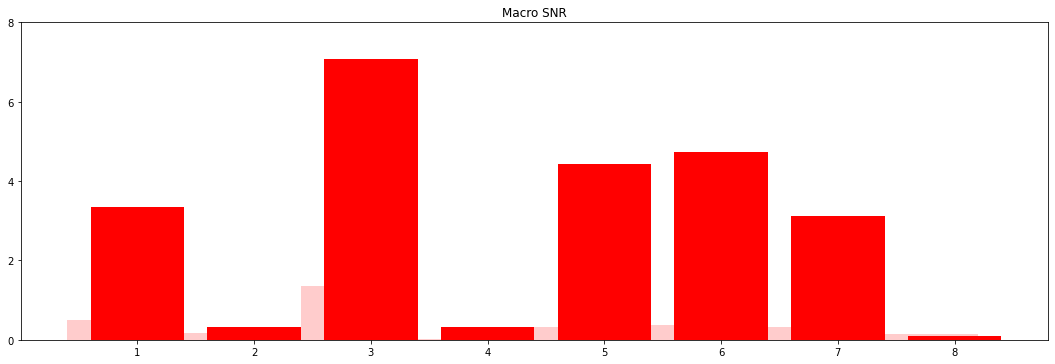

In [8]:
# First, clear old plot if one exists
plt.clf()
# Create figures (2 plots)
fig, (macro_snr_src_plot) = plt.subplots(1, 
    figsize=(15,5), gridspec_kw={'width_ratios': [1]})
fig.tight_layout()
    
macro_trial_1_wfm = np.sum(macro_waveforms_trials[waveforms_snr_source_index][0], axis=0)
macro_avg_wfms = np.mean(macro_waveforms_trials[waveforms_snr_source_index], axis=0)

# Bar chart plot for all sources SNR    
# Macro
for idx, row in enumerate(macro_snr_vec_avg):
    macro_snr_src_plot.bar(idx+1, height=row[num_trials-1], color='r')
    macro_snr_src_plot.bar(idx+0.8, height=row[0], color='r', alpha=0.2)

macro_snr_src_plot.set_xticks([1,2,3,4,5,6,7,8])
macro_snr_src_plot.set_yticks([0,2,4,6,8])
macro_snr_src_plot.title.set_text("Macro SNR")

plt.savefig('/home/jovyan/ansys_data/images/8-source-2-mm.eps', format='eps', dpi=500)
plt.show()